In [1]:
import pandas as pd
import nltk
from matplotlib import pyplot as plt
from scrape_data import *
from process_text import *
from helper import *

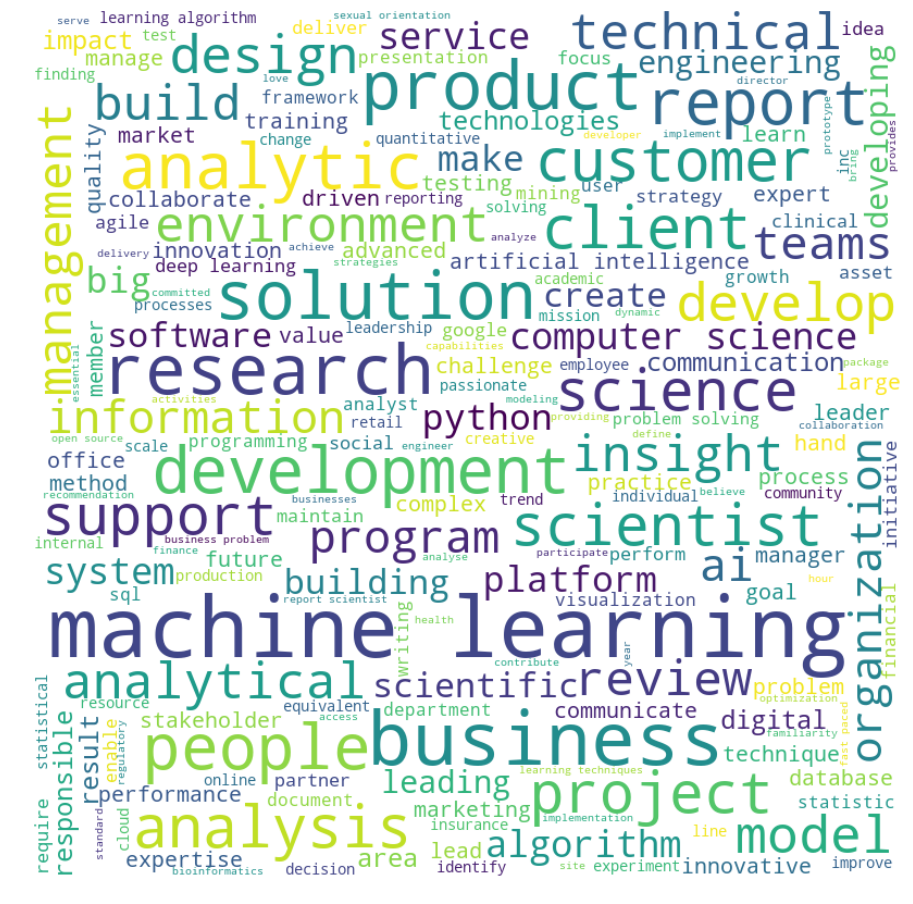

In [2]:
plot_profile('data scientist', max_words=200, first_n_postings=120)

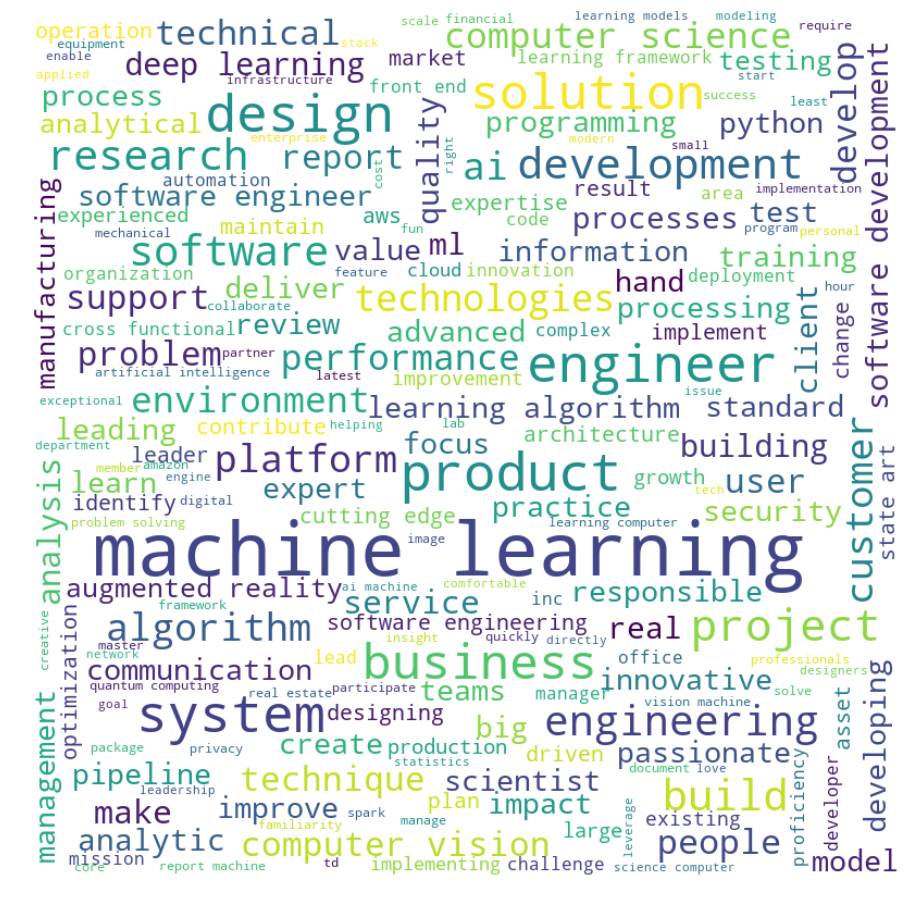

In [3]:
plot_profile('machine learning engineer', max_words=200, first_n_postings=120)

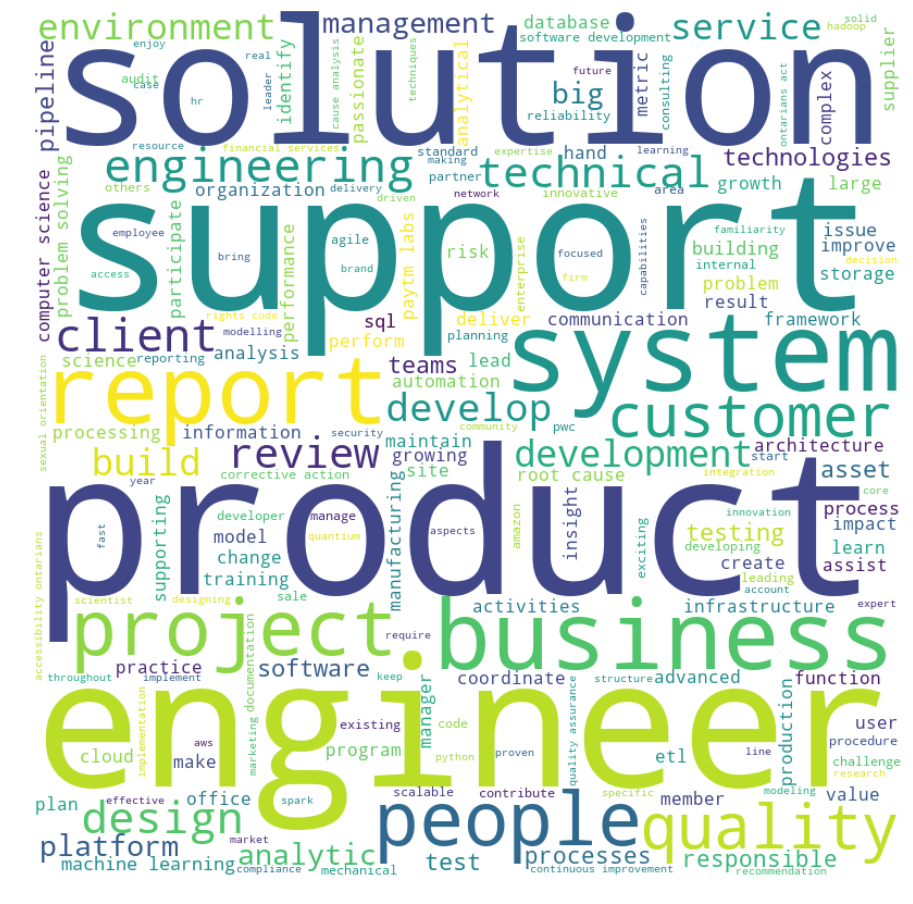

In [4]:
plot_profile('data engineer', max_words=200, first_n_postings=120)

In [5]:
# Initialize the dict to store all text lists for below titles
text_lists = {}
titles = ['Data Scientist', 'Machine Learning Engineer', 'Data Engineer']
# Grab the tokens list and store them in the dict
for title in titles:
    text_lists[title] = plot_profile(title=title, first_n_postings=120, return_text_list=True)

In [6]:
# Make the dict of skills to investigate

languages = ['Python', 'R', 'SQL', 'Java', 'C', 'C++', 'C#', 'Scala',
             'Perl', 'Julia', 'Javascript', 'HTML', 'CSS'] 

big_data = ['Hadoop', 'MapReduce', 'Hive', 'Pig', 'Cascading', 'Scalding', 'Cascalog', 'HBase', 'Sqoop', 
            'Mahout', 'Oozie', 'Flume', 'ZooKeeper', 'Spark', 'Storm', 'Shark', 'Impala', 'Elasticsearch', 
            'Kafka', 'Flink', 'Kinesis', 'Presto', 'Hume', 'Airflow', 'Azkabhan', 'Luigi']

dl = ['TensorFlow', 'Keras', 'PyTorch', 'Theano', 'Deeplearning4J', 'Caffe', 'TFLearn', 'Torch', 
      'OpenCV', 'MXNet', 'Microsoft Cognitive Toolkit', 'Lasagne']

cloud = ['AWS', 'GCP', 'Azure']

ml = ['Natural Language Processing', 'Computer Vision', 'Voice Recognition', 'Fraud Detection',
      'Recommendation Engine', 'Recommender System', 'Image Recognition', 'Object Dectection', 
      'Chatbot',  'Sentiment Analysis']

visualization = ['Dimple', 'D3.js', 'Ggplot', 'Shiny', 'Plotly', 'Matplotlib', 'Seaborn', 
                'Bokeh', 'Tableau']

other = ['Pandas', 'Numpy', 'Scipy', 'Sklearn', 'Scikit-Learn', 'Docker', 'Git']

dict_to_check = {'Programming Languages': languages,
                 'Big Data Technologies': big_data,
                 'Deep Learning Frameworks': dl,
                 'Cloud Computing Platforms': cloud,
                 'Machine Learning Application': ml,
                 'Visualization Tools': visualization,
                 'Other': other}

dict_to_check

{'Programming Languages': ['Python',
  'R',
  'SQL',
  'Java',
  'C',
  'C++',
  'C#',
  'Scala',
  'Perl',
  'Julia',
  'Javascript',
  'HTML',
  'CSS'],
 'Big Data Technologies': ['Hadoop',
  'MapReduce',
  'Hive',
  'Pig',
  'Cascading',
  'Scalding',
  'Cascalog',
  'HBase',
  'Sqoop',
  'Mahout',
  'Oozie',
  'Flume',
  'ZooKeeper',
  'Spark',
  'Storm',
  'Shark',
  'Impala',
  'Elasticsearch',
  'Kafka',
  'Flink',
  'Kinesis',
  'Presto',
  'Hume',
  'Airflow',
  'Azkabhan',
  'Luigi'],
 'Deep Learning Frameworks': ['TensorFlow',
  'Keras',
  'PyTorch',
  'Theano',
  'Deeplearning4J',
  'Caffe',
  'TFLearn',
  'Torch',
  'OpenCV',
  'MXNet',
  'Microsoft Cognitive Toolkit',
  'Lasagne'],
 'Cloud Computing Platforms': ['AWS', 'GCP', 'Azure'],
 'Machine Learning Application': ['Natural Language Processing',
  'Computer Vision',
  'Voice Recognition',
  'Fraud Detection',
  'Recommendation Engine',
  'Recommender System',
  'Image Recognition',
  'Object Dectection',
  'Chatbot',


In [7]:
# Check the frequency and store in dict
freq_dict = {}
for title in text_lists.keys():
    freq_dict[title] = check_freq(dict_to_check=dict_to_check, text_list=text_lists[title])

In [8]:
# Convert the dict to a pandas df
df = pd.DataFrame.from_dict({(i,j): freq_dict[i][j] 
                             for i in freq_dict.keys()
                             for j in freq_dict[i].keys()},
                            orient='index')
df.head()

Python   R  SQL  Java   C  C++  \
Data Engineer Big Data Technologies            NaN NaN  NaN   NaN NaN  NaN   
              Cloud Computing Platforms        NaN NaN  NaN   NaN NaN  NaN   
              Deep Learning Frameworks         NaN NaN  NaN   NaN NaN  NaN   
              Machine Learning Application     NaN NaN  NaN   NaN NaN  NaN   
              Other                            NaN NaN  NaN   NaN NaN  NaN   

                                            C#  Scala  Perl  Julia  ...   \
Data Engineer Big Data Technologies        NaN    NaN   NaN    NaN  ...    
              Cloud Computing Platforms    NaN    NaN   NaN    NaN  ...    
              Deep Learning Frameworks     NaN    NaN   NaN    NaN  ...    
              Machine Learning Application NaN    NaN   NaN    NaN  ...    
              Other                        NaN    NaN   NaN    NaN  ...    

                                            Seaborn  Bokeh  Tableau  Pandas  \
Data Engineer Big Data Technologies             NaN    NaN      NaN     NaN   
              Cloud Computing Platforms         NaN    NaN      NaN     NaN   
              Deep Learning Frameworks          NaN    NaN      NaN     NaN   
              Machine Learning Application      NaN    NaN      NaN     NaN   
              Other                             NaN    NaN      NaN     3.0   

                                            Numpy  Scipy  Sklearn  \
Data Engineer Big Data Technologies           NaN    NaN      NaN   
              Cloud Computing Platforms       NaN    NaN      NaN   
              Deep Learning Frameworks        NaN    NaN      NaN   
              Machine Learning Application    NaN    NaN      NaN   
              Other                           0.0    2.0      0.0   

                                            Scikit-Learn  Docker   Git  
Data Engineer Big Data Technologies                  NaN     NaN   NaN  
              Cloud Computing Platforms              NaN     NaN   NaN  
              Deep Learning Frameworks               NaN     NaN   NaN  
              Machine Learning Application           NaN     NaN   NaN  
              Other                                  0.0     8.0  29.0  

[5 rows x 80 columns]

In [9]:
# Reset the index to include both title and category as columns
df = df.reset_index()
df.head()

,level_0,level_1,Python,R,SQL,Java,C,C++,C#,Scala,...,Seaborn,Bokeh,Tableau,Pandas,Numpy,Scipy,Sklearn,Scikit-Learn,Docker,Git
0,Data Engineer,Big Data Technologies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Data Engineer,Cloud Computing Platforms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Data Engineer,Deep Learning Frameworks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Data Engineer,Machine Learning Application,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Data Engineer,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,0.0,2.0,0.0,0.0,8.0,29.0


In [10]:
# Rename the first two columns
df.rename({'level_0': 'title', 'level_1': 'category'}, axis='columns', inplace=True)
df.head()

,title,category,Python,R,SQL,Java,C,C++,C#,Scala,...,Seaborn,Bokeh,Tableau,Pandas,Numpy,Scipy,Sklearn,Scikit-Learn,Docker,Git
0,Data Engineer,Big Data Technologies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Data Engineer,Cloud Computing Platforms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Data Engineer,Deep Learning Frameworks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Data Engineer,Machine Learning Application,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Data Engineer,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,0.0,2.0,0.0,0.0,8.0,29.0


In [11]:
value_vars = df.columns.tolist()[2:] # the list of column names except the first two
# Transform from wide to long for plotting
df = pd.melt(df, id_vars=['title', 'category'], value_vars=value_vars)
df.head()

,title,category,variable,value
0,Data Engineer,Big Data Technologies,Python,NaN
1,Data Engineer,Cloud Computing Platforms,Python,NaN
2,Data Engineer,Deep Learning Frameworks,Python,NaN
3,Data Engineer,Machine Learning Application,Python,NaN
4,Data Engineer,Other,Python,NaN


In [12]:
# Rename the last two columns
df.rename({'variable': 'skill', 'value': 'frequency'}, axis='columns', inplace=True)
df.head()

,title,category,skill,frequency
0,Data Engineer,Big Data Technologies,Python,NaN
1,Data Engineer,Cloud Computing Platforms,Python,NaN
2,Data Engineer,Deep Learning Frameworks,Python,NaN
3,Data Engineer,Machine Learning Application,Python,NaN
4,Data Engineer,Other,Python,NaN


In [13]:
# Subset to non null values in the freq column
df = df[df['frequency'].notnull()]
df.head()

,title,category,skill,frequency
5,Data Engineer,Programming Languages,Python,52.0
12,Data Scientist,Programming Languages,Python,103.0
19,Machine Learning Engineer,Programming Languages,Python,71.0
26,Data Engineer,Programming Languages,R,5.0
33,Data Scientist,Programming Languages,R,19.0


In [14]:
# Reset the index
df.reset_index(drop=True, inplace=True)
df.head()

,title,category,skill,frequency
0,Data Engineer,Programming Languages,Python,52.0
1,Data Scientist,Programming Languages,Python,103.0
2,Machine Learning Engineer,Programming Languages,Python,71.0
3,Data Engineer,Programming Languages,R,5.0
4,Data Scientist,Programming Languages,R,19.0


In [15]:
df.shape

(240, 4)

In [16]:
df = df.astype({'frequency': int})
df.dtypes

title        object
category     object
skill        object
frequency     int32
dtype: object

In [17]:
df.head()

,title,category,skill,frequency
0,Data Engineer,Programming Languages,Python,52
1,Data Scientist,Programming Languages,Python,103
2,Machine Learning Engineer,Programming Languages,Python,71
3,Data Engineer,Programming Languages,R,5
4,Data Scientist,Programming Languages,R,19


In [18]:
df['category'].unique()

array(['Programming Languages', 'Big Data Technologies',
       'Deep Learning Frameworks', 'Cloud Computing Platforms',
       'Machine Learning Application', 'Visualization Tools', 'Other'],
      dtype=object)

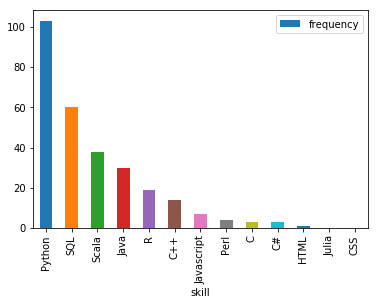

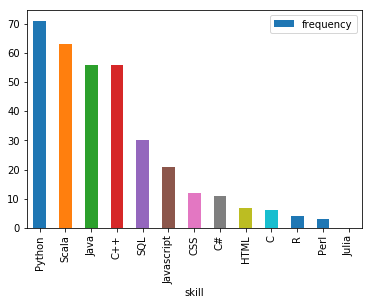

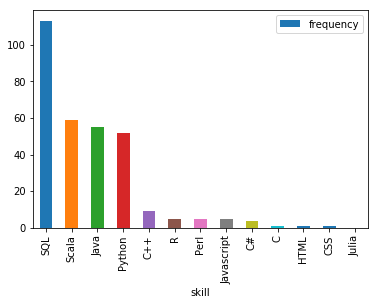

In [19]:
for title in titles:
    plot_skill(df=df, title=title, category='Programming Languages')

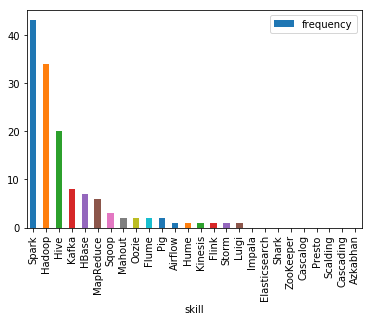

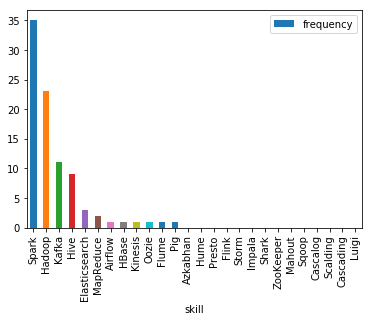

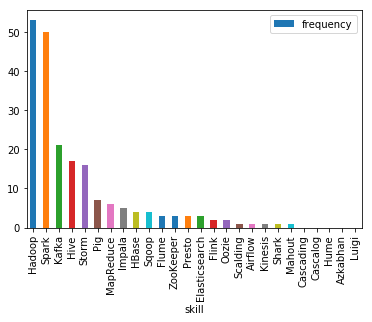

In [20]:
for title in titles:
    plot_skill(df=df, title=title, category='Big Data Technologies')

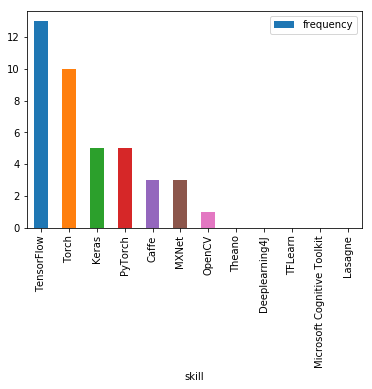

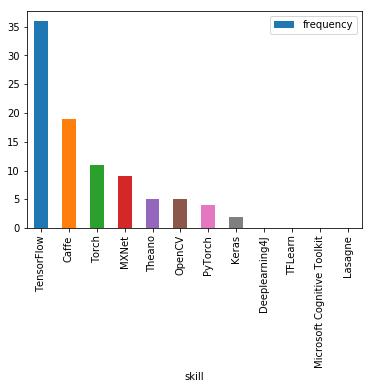

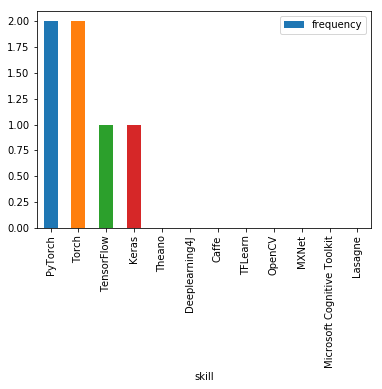

In [21]:
for title in titles:
    plot_skill(df=df, title=title, category='Deep Learning Frameworks')

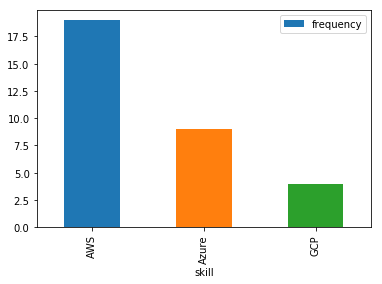

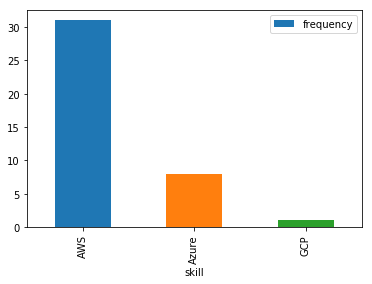

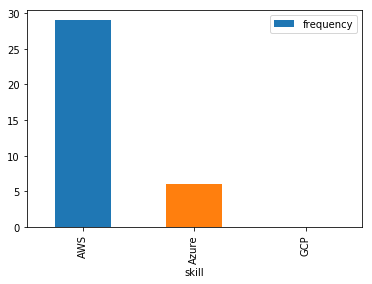

In [22]:
for title in titles:
    plot_skill(df=df, title=title, category='Cloud Computing Platforms')

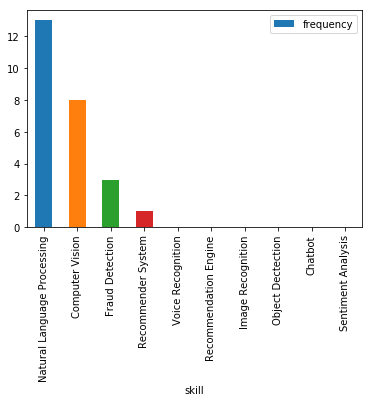

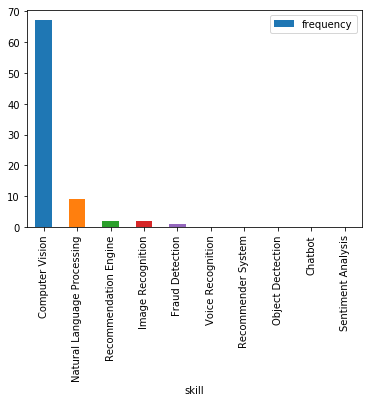

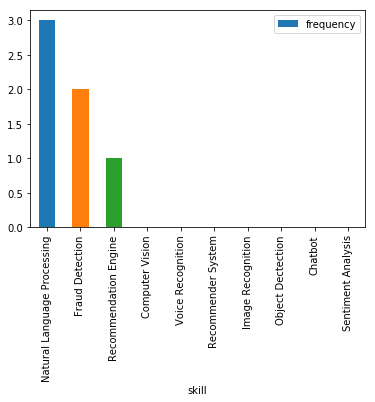

In [23]:
for title in titles:
    plot_skill(df=df, title=title, category='Machine Learning Application')

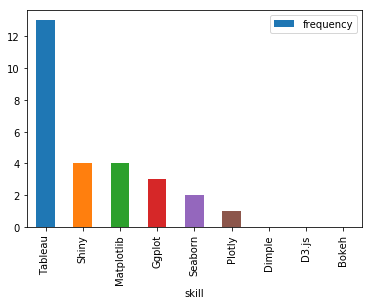

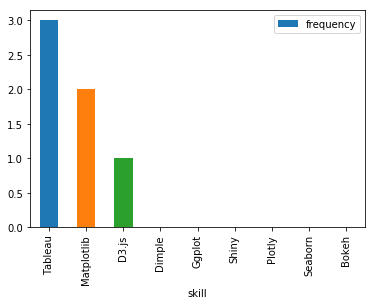

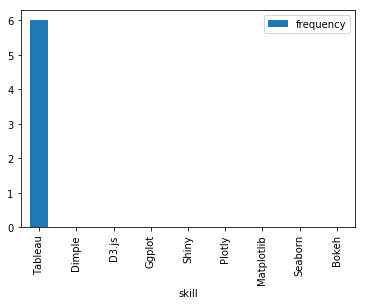

In [24]:
for title in titles:
    plot_skill(df=df, title=title, category='Visualization Tools')

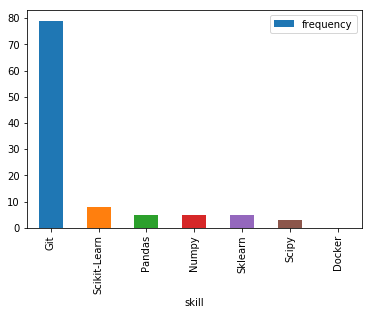

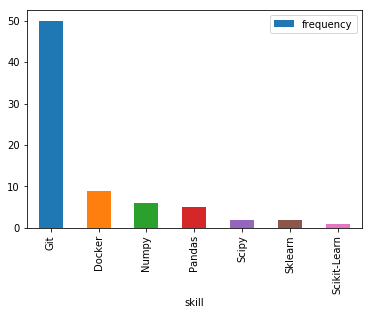

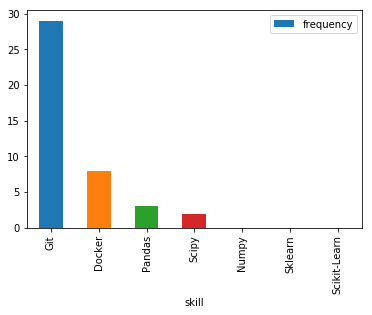

In [25]:
for title in titles:
    plot_skill(df=df, title=title, category='Other')

In [ ]:
"""
with open('stopwords.csv', 'r', newline='') as f:
    reader = csv.reader(f)
    stop_list = list(reader)[0]
print(stop_list)
"""


"""
# Get the most frequent 300 tokens
freq = nltk.FreqDist(text)
tokens_top_300 = [i[0] for i in freq.most_common(300)]
# Save to a csv file for manual filtering
with open('stopwords_tmp.csv', 'w', newline='') as f:
     wr = csv.writer(f, quoting=csv.QUOTE_ALL)
     wr.writerow(tokens_top_300)
"""

## Todo's
- /
- subplot, plot title
- Seaborn
- show word context
- investigate for pandas, numpy etc packages and plotting tools
- docstring and comments
- OOP
- single responsiblity principle for functions
- assumptions and limitations (sample representative...)